## Lattice Perturbation Experiment

This simulation studies how the Lasso regression model evolves as we continuously deform a regular lattice into a random geometric graph. Starting from a perfect square (or triangular) lattice at `perturb_scale = 0`, nodes are progressively displaced by increasing amounts, with the perturbation scale serving as a proxy for the degree of geometric disorder.

The central question is how the functional form of effective resistance (in terms of distance, angle, and degree) changes across this deformation.

### Scaling the radius multiplier Across Lattice Orders

We noticed that when we perturb the nodes of the lattice while keeping the same radius of connection the mean degree of our graphs dropped significantly, thus we have added a correction term. The term `perturb_radius_multiplier_` is calculated as follows. Let $k_0$ denote the degree of a node and $k$ denote the epxected mean degree. We know that $k = \mathbb{E}[k_0] = n \pi r^2$ with $n$ the number of nodes in the graph and $r$ the radius of connection. 

For the order 1 square lattice i.e. only nearst vertices are connected, we have $r = \frac{1}{\sqrt{n}}$. Thus if we want the perturbed graph's expected mean degree to match that of the order 1 square lattice we need to scale our radius by some positive scalar $c$ so that: $$4 = n \pi (cr)^2 \implies \frac{4}{\pi} = c^2 \implies c = \frac{2}{\sqrt{\pi}} \approx 1.128$$

When the lattice is of higher order we repeat the same process, but with $r = \frac{d}{\sqrt{n}}$ where $d$ is ratio of the max distance between neighboring nodes and the minimum distance between neighboring nodes.

We note this is an approxiamted term due to the fact that these perturbed lattices follow a different distribution than the standard RGGs where we uniformly randomly place vertices on the torus. However, this approximation works well numerically.

We provide a function radius_multiplier_calc_square_lattice() to calculate the radius multiplier using the following inputs:
- Order 1: $1, 4$ 
- Order 2: $\sqrt{2}, 8$
- Order 3: $2, 12$
- Order 4: $\sqrt{5}, 20$
- Order 5: $\sqrt{8}, 24$

Starting Geometric Experiment: 11 steps.
Step 1: Perturb=False (Perfect Lattice)
Steps 2+: Perturb=True (Scale epsilon -> 1.5)


100%|██████████| 11/11 [00:14<00:00,  1.34s/it]


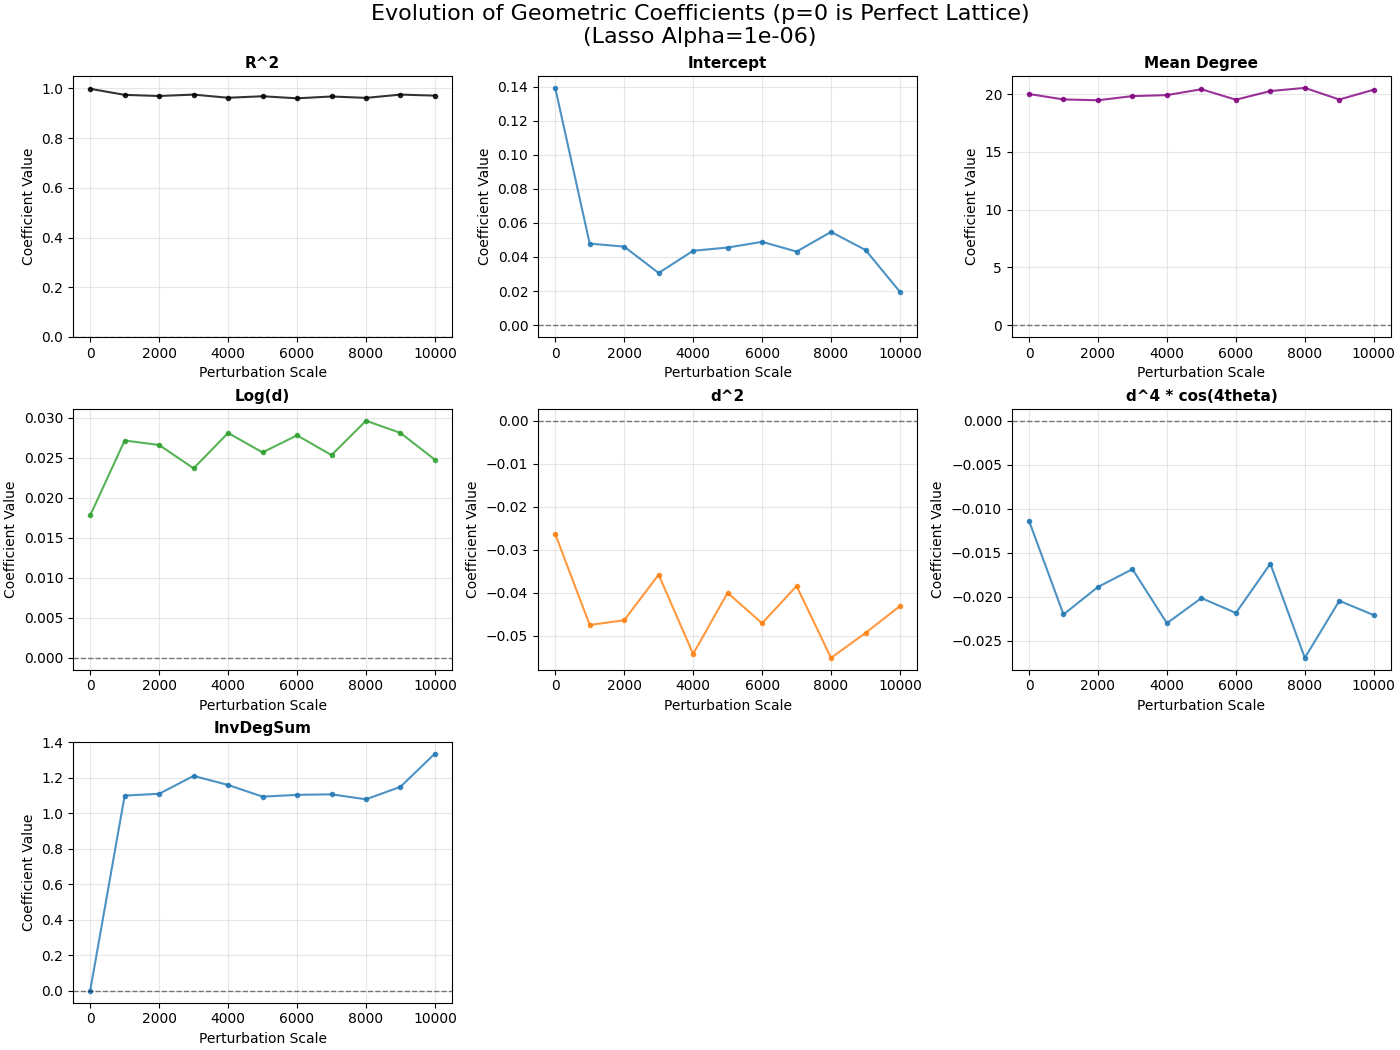

In [16]:
%matplotlib widget
import numpy as np
import networkx as nx
import random
import matplotlib.pyplot as plt
import sys
import warnings
from tqdm import tqdm  # For progress bar

# --- IMPORTS FOR ML ---
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# --- USER PATH ---
from RGG_Library import RGGBuilder

# --------------------------------------------------------------------------------
# PERTURBATION MULTIPLIER HELPER FUNCTION
# --------------------------------------------------------------------------------
def radius_multiplier_calc_square_lattice(dist, exp_k):
    return np.sqrt(exp_k / (dist**2 * np.pi))

# --------------------------------------------------------------------------------
# CONFIGURATION
# --------------------------------------------------------------------------------
space_ = "square_torus"
use_angles = True

# Experiment Range: 0.0, then 0.02 to 1.5
perturb_values = np.concatenate(([0.0], np.arange(1000, 11000, 1000)))

# Fixed Graph Parameters
N_NODES = 256
K_NEIGHBORS = 20
N_SAMPLES = 1000
LASSO_ALPHA = 1e-6
ORDER = 4
MAX_DIST_FOR_ORDER = np.sqrt(5)
DEGREE_FOR_ORDER = 20

perturb_radius_multiplier_ = radius_multiplier_calc_square_lattice(MAX_DIST_FOR_ORDER, DEGREE_FOR_ORDER)

# --------------------------------------------------------------------------------
# SIMULATION FUNCTION
# --------------------------------------------------------------------------------
def get_coefficients_for_perturbation(perturb_val, iteration_seed):
    """
    Generates a graph, runs Lasso, and returns Real Coefs + Intercept + Mean Degree.
    """
    
    # --- 1. Graph Generation ---
    if perturb_val == 0.0:
        is_perturbed = False
        current_scale = 0.0
    else:
        is_perturbed = True
        current_scale = perturb_val
    
    builder = RGGBuilder(
        n=N_NODES,
        k=K_NEIGHBORS,
        connectivity_regime="sc",
        space=space_,
        order=ORDER,
        perturb=is_perturbed,
        perturb_scale=current_scale,
        perturb_radius_multiplier=perturb_radius_multiplier_,
        seed=iteration_seed
    )
    
    G = builder.build()

    # Ensure Giant Component
    if not nx.is_connected(G):
        components = list(nx.connected_components(G))
        Gsub = G.subgraph(max(components, key=len)).copy()
    else:
        Gsub = G
    
    Gsub = nx.convert_node_labels_to_integers(Gsub, ordering="sorted")

    # --- NEW: Calculate Mean Degree ---
    # (2 * edges) / nodes
    mean_degree = 2 * Gsub.number_of_edges() / Gsub.number_of_nodes()

    # --- 2. Sample Data ---
    random.seed(iteration_seed)
    np.random.seed(iteration_seed)
    
    if use_angles:
        res, degs, dists, pairs, angles = RGGBuilder.sample_commute_times_even_distance_w_angles(
            Gsub, nsamples=N_SAMPLES, n_bins=20, seed=iteration_seed, 
            min_dist=builder.radius, max_dist=2
        )
    else:
        res, degs, dists, pairs = RGGBuilder.sample_commute_times_even_distance(
            Gsub, nsamples=N_SAMPLES, n_bins=20, seed=iteration_seed, 
            min_dist=builder.radius, max_dist=2
        )
        angles = np.zeros_like(dists)

    # --- 3. Feature Engineering ---
    safe_dists = dists.copy()
    safe_dists[safe_dists == 0] = 1e-9 

    # Define features based on perturbation state
    if is_perturbed == False:
        feature_dict = {
            "Log(d)": np.log(safe_dists),
            "d^2": dists**2,
            "d^4 * cos(4theta)": dists**4 * np.cos(4*angles),
        }
    else:
        feature_dict = {
            "Log(d)": np.log(safe_dists),
            "d^2": dists**2,
            "d^4 * cos(4theta)": dists**4 * np.cos(4*angles),
            "InvDegSum": degs,
        }

    feature_names = list(feature_dict.keys())
    X = np.column_stack(list(feature_dict.values()))
    y = res

    # --- 4. Lasso Regression ---
    model = make_pipeline(
        StandardScaler(), 
        Lasso(alpha=LASSO_ALPHA, max_iter=50000, tol=1e-4)
    )
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        model.fit(X, y)
        # --- NEW: Calculate R^2 Score ---
        r2_score = model.score(X, y)

    # --- 5. Extract Unscaled Coefficients & Intercept ---
    lasso = model.named_steps['lasso']
    scaler = model.named_steps['standardscaler']
    
    sigmas = scaler.scale_
    sigmas[sigmas == 0] = 1.0 
    
    real_coefs = lasso.coef_ / sigmas
    real_intercept = lasso.intercept_ - np.dot(real_coefs, scaler.mean_)

    # Create result dictionary
    results = dict(zip(feature_names, real_coefs))
    
    # Add metadata
    results["Intercept"] = real_intercept
    results["Mean Degree"] = mean_degree
    results["R^2"] = r2_score  # <--- Added
    
    return results

# --------------------------------------------------------------------------------
# MAIN EXECUTION LOOP
# --------------------------------------------------------------------------------

history = {key: [] for key in [
    "R^2",
    "Intercept",
    "Mean Degree",
    "Log(d)", 
    "d^2", 
    "d^4 * cos(4theta)", 
    "InvDegSum",
]}

print(f"Starting Geometric Experiment: {len(perturb_values)} steps.")
print("Step 1: Perturb=False (Perfect Lattice)")
print("Steps 2+: Perturb=True (Scale epsilon -> 1.5)")

perturb_vals_plotted = []

for i, p in enumerate(tqdm(perturb_values)):
    try:
        coefs = get_coefficients_for_perturbation(p, iteration_seed=0)
        
        for key in history.keys():
            history[key].append(coefs.get(key, 0.0))
        
        perturb_vals_plotted.append(p)
            
    except Exception as e:
        print(f"Skipping p={p:.2f} due to error: {e}")

# --------------------------------------------------------------------------------
# VISUALIZATION
# --------------------------------------------------------------------------------

features_to_plot = list(history.keys())
n_feats = len(features_to_plot)
cols = 3
rows = (n_feats // cols) + (1 if n_feats % cols > 0 else 0)

fig, axes = plt.subplots(rows, cols, figsize=(14, 3.5 * rows), constrained_layout=True)
axes = axes.flatten()

for i, feature_name in enumerate(features_to_plot):
    ax = axes[i]
    y_vals = history[feature_name]
    
    if feature_name == "R^2":
        color = 'black'
        ax.set_ylim(0, 1.05)
    elif "Log" in feature_name: color = 'tab:green'
    elif "1/" in feature_name: color = 'tab:red'
    elif "^2" in feature_name: color = 'tab:orange'
    elif "Degree" in feature_name: color = 'purple'
    else: color = 'tab:blue'
    
    ax.plot(perturb_vals_plotted, y_vals, marker='o', markersize=3, linewidth=1.5, color=color, alpha=0.8)
    ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.5)
    
    ax.set_title(feature_name, fontsize=11, fontweight='bold')
    ax.set_xlabel("Perturbation Scale")
    ax.set_ylabel("Coefficient Value")
    ax.grid(True, alpha=0.3)

for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.suptitle(f"Evolution of Geometric Coefficients (p=0 is Perfect Lattice)\n(Lasso Alpha={LASSO_ALPHA})", fontsize=16)
plt.show()